# CNN Tutorial

## Understanding convolutions

Suppose we have the following input image:

$\begin{bmatrix}
0 & 10  & 9 & 10 & 0 \\
0 & 0  & 0 & 10 & 0 \\
0 & 10  & 9 & 10 & 0 \\
0 & 0  & 0 & 10 & 0 \\
0 & 10  & 9 & 10 & 0 \\
\end{bmatrix}
$

and we use the following $3 \times 3$ filter with stride 1:

$\begin{bmatrix}
0 & 1  & 0\\
0 & 1  & 0 \\
0 & 1  & 0 
\end{bmatrix}
$

1. What is the dimension of the output? What is the output? *Assume no 0-padding
2. How many parameters do we use? How does this compare to a fully connected network that goes from the (flattened) input dimension above (e.g., 25) to the (flattened) output dimension computed in Q1?
3. Instead of applying the filter to the input directly, suppose we pad the original image by $1$ on all sides. What is the new dimension of the output? What is the output?

## Building an MNIST Classifier

In [81]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [82]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu')

In [83]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())

# Data Loading
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [84]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Transforms a 1-channel image to 16 channels, using 5x5 kernels
        # Output is equivalent to a 16 channel image, of half the size (due to max pooling)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            # Batchnorm approximately normalizes input to zero-mean & unit-variance
            # Keeps running values for mean and variance
            # Also linearly transforms the output with learnable params
            nn.BatchNorm2d(16),
            # ReLU non-linearity
            nn.ReLU(),
            # Max pooling (shrinks output by 1/2, to 14x14)
            nn.MaxPool2d(2))
        # Equivalent to transforming from 16 to 32 layers
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # Shrink to 7x7
            nn.MaxPool2d(2))
        # Input: equivalent of a 7x7 image with 32 channels
        # Output: 10 units for 10 digit classes
        self.fc = nn.Linear(7*7*32, 10)
    # Define the forward pass
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

### Train the MNIST Classifier

In [89]:
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Model, loss, and optimizer
cnn = CNN()
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)              # Forward
        loss = criterion(outputs, labels)  # Compute loss
        optimizer.zero_grad()              # Clear stored gradients
        loss.backward()                    # Compute gradients
        optimizer.step()                   # Update weights

#         if (i+1) % 100 == 0:
#             print('Epoch [{}/{}], Iter [{}/{}] Loss: {:6.4f}'.format(
#                   (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item())))

In [91]:
### Test the Model ###
# Change model to 'eval' mode
# This affects the batch normalization layer, so that it uses the mean/variance obtained in training
cnn.eval()  

# Compute accuracy
correct = 0
total = 0

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Test Accuracy (10000 test images): %d %%' % (100 * correct / total))

Test Accuracy (10000 test images): 98 %


Input image
torch.Size([1, 1, 28, 28])


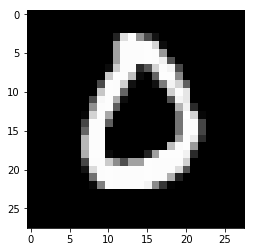

Image after layer 1
torch.Size([1, 16, 14, 14])


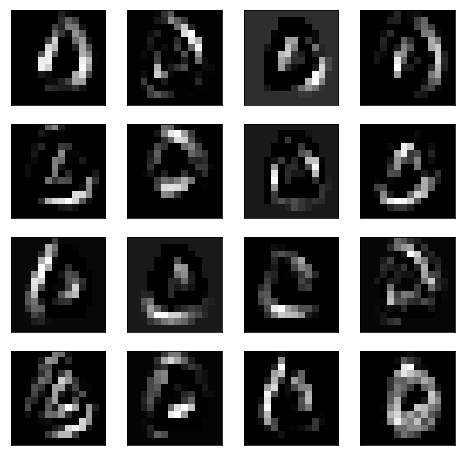

Image after layer 2
torch.Size([1, 32, 7, 7])


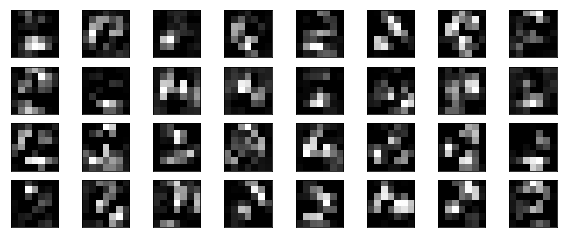

In [101]:
### Let's visualize a training image through the convolution layers ###
# Read in a training image 
trainIter = iter(train_loader) 
images, labels = trainIter.next() 
img = torch.unsqueeze(images[0], 0)
img = img.to(device)
fig, ax = plt.subplots()
ax.imshow(img.cpu().numpy().reshape((28,28)), cmap = plt.cm.gray)
print('Input image')
print(img.shape) # 1 image, 1 channel, WxH = 28x28
plt.show()
img_after_layer1 = cnn.layer1(img)
print('Image after layer 1')
print(img_after_layer1.shape) # 1 image, 16 channels, WxH = 14x14
nChannels = img_after_layer1.data.shape[1]
f, axarr = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    axarr[i//4,i%4].imshow(img_after_layer1.data[0,i,:,:].detach().cpu().numpy().reshape((14,14)),
                           cmap = plt.cm.gray, interpolation='nearest', aspect='equal')
for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
print('Image after layer 2')
img_after_layer2 = cnn.layer2(img_after_layer1)
print(img_after_layer2.shape) # 1 image, 32 channel, WxH = 7x7
f2, axarr2 = plt.subplots(4, 8, figsize=(10,4))
for i in range(32):
    axarr2[i//8,i%8].imshow(img_after_layer2.data[0,i,:,:].detach().cpu().numpy().reshape((7,7)),
                            cmap = plt.cm.gray, interpolation='nearest', aspect='equal')
for ax in axarr2.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

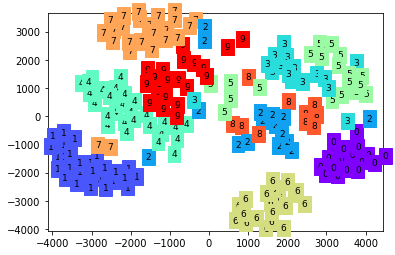

In [96]:
###########################################################################
# Visualize labels clustering based on output from con via tsne
# Note: requires sklearn
# Adapted from: https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/401_CNN.py
###########################################################################
# Grab some test data
plot_only = 200
test_x = torch.unsqueeze(test_dataset.test_data,1).type(torch.FloatTensor)[:plot_only]
test_y = test_dataset.test_labels[:plot_only]

test_x, test_y = test_x.to(device), test_y.to(device)

# Define a partial forward pass, which returns the representation before the fully connected layer is run
def forwardInclPreFinal(x):
    out = cnn.layer2(cnn.layer1(x))
    outv = out.view(out.size(0), -1)
    return outv

before_last_layer = forwardInclPreFinal(test_x)
# Plot tsne clustering based on conv layer outputs, with labels of correct answer
from matplotlib import cm
from sklearn.manifold import TSNE

def plot_with_labels(lowDWeights, labels):
    plt.cla() # Clear current axis
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()) 
    plt.ylim(Y.min(), Y.max())
    plt.show()

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(before_last_layer.detach().cpu().numpy()[:plot_only, :])
labels = test_dataset.test_labels.numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels)

## Building a CIFAR-10 Classifier

Adapted from the PyTorch Tutorials, "Training a Classifier"

In [74]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Classes of images
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Read in the training & testing data
batch_size = 32

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


bird, cat, deer, frog, bird, deer, deer, dog, bird, dog, deer, frog, dog, plane, car, dog, frog, truck, frog, ship, bird, frog, plane, deer, bird, truck, truck, bird, frog, bird, dog, horse


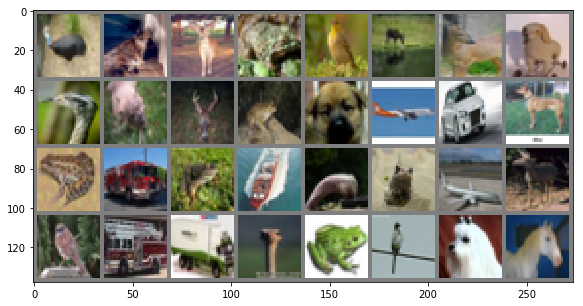

In [35]:
# Let's look at some example training images
dataiter = iter(trainloader)      # For training images
testdataiter = iter(testloader)   # For testing images (used later)
images, labels = dataiter.next()  # Ask the iterator for some images

# Show images and labels
plt.figure(figsize=(10,5))
plt.imshow(np.transpose(torchvision.utils.make_grid(images).numpy() / 2 + 0.5, (1, 2, 0)))
print(', '.join(classes[labels[j]] for j in range(iterBatchSize)))

In [36]:
# Define a small CNN that processes 3-channel images
class Net(nn.Module):
    # Initialize our layers, i.e. the set of trainable parameters
    def __init__(self):
        super(Net, self).__init__()
        # A convolutional layer
        # The number of input channels is 3 this time (rgb)
        self.conv1 = nn.Conv2d(3, 6, 5)
        # A max pooling layer (will be reused for each conv layer)
        self.pool = nn.MaxPool2d(2, 2)
        # Another convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Three sets of fully connected (linear) layers 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # For each conv layer: conv -> relu -> pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Reshape from higher dimensional tensor to a vector for the FC layers
        x = x.view(-1, 16 * 5 * 5)
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net = net.to(device)

In [37]:
# Look at the weights and network structure
print(net.state_dict().keys())
print("Conv1:",net.conv1.weight.size())
print("Conv2:",net.conv2.weight.size())
print(net.conv1.weight[3,:,:,:])
print(net.conv2.weight.size())
print(net.conv2.weight[3,:,:,:])

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
Conv1: torch.Size([6, 3, 5, 5])
Conv2: torch.Size([16, 6, 5, 5])
tensor([[[ 0.0112, -0.0312,  0.0415, -0.0140,  0.0245],
         [ 0.1061,  0.0328, -0.0014, -0.0158,  0.0722],
         [ 0.0034,  0.0642,  0.0868,  0.0084, -0.0650],
         [ 0.0395, -0.1043, -0.0858,  0.1154,  0.0409],
         [-0.0342, -0.1149, -0.0592, -0.0139,  0.0322]],

        [[-0.0577, -0.0009, -0.0466, -0.0177,  0.0128],
         [-0.0660,  0.0845,  0.0044,  0.0633, -0.0261],
         [ 0.0078, -0.0955, -0.0949, -0.1127, -0.0688],
         [ 0.0957, -0.0666,  0.0434, -0.0330, -0.0358],
         [-0.0656,  0.0455,  0.1153,  0.0315, -0.0814]],

        [[ 0.1031,  0.0664, -0.0932,  0.0853,  0.0778],
         [-0.1141, -0.0431,  0.0790, -0.0046,  0.0982],
         [-0.0391, -0.0911,  0.0331,  0.0563, -0.0264],
         [-0.0126,  0.1066, -0.0756, -0.0514, -0.077

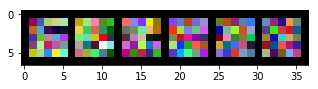

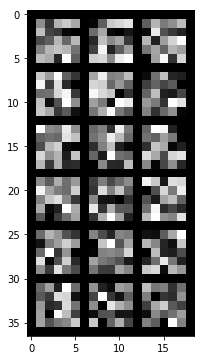

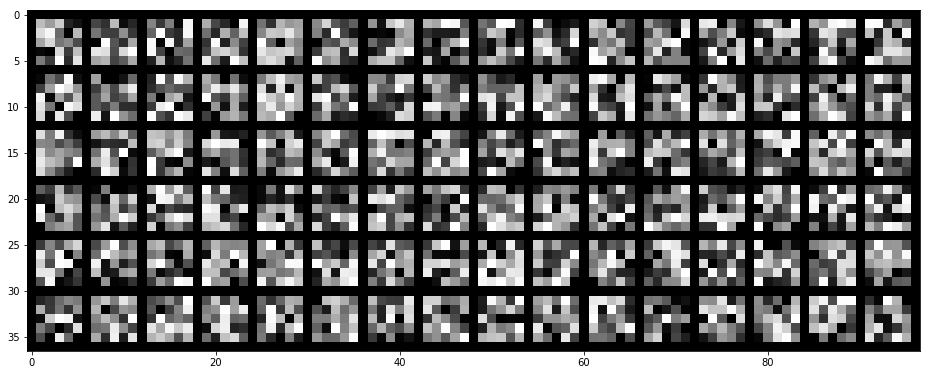

In [38]:
from torchvision import utils

# Define a method to help visualize the convolutional kernels
# From: https://github.com/pedrodiamel/nettutorial/blob/master/pytorch/pytorch_visualization.ipynb
def vistensor(tensor, ch=0, allkernels=False, ncol=8, padding=1): 
    n, c, w, h = tensor.shape
    if allkernels:
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3:
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min((tensor.shape[0]//ncol + 1, 64 ))
    grid = utils.make_grid(tensor, nrow=ncol, normalize=True, padding=padding, scale_each=True)
    plt.figure(figsize=(ncol,rows))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))
    plt.show()

# Visualize the parameters of tensors before training (just noise)
vistensor(net.conv1.weight.data) # Can view the first conv layer's kernels as being RGB
# Or treat each of the 6 units as having 3 greyscale filters
vistensor(net.conv1.weight.data, allkernels=True, ncol=3) 
# The second layer's filters
vistensor(net.conv2.weight.data, allkernels=True, ncol=16)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):
    running_loss = 0.0
    num_total = 0.0
    num_correct = 0.0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)              # Forward
        loss = criterion(outputs, labels)  # Compute loss
        optimizer.zero_grad()              # Zero the parameter gradients
        loss.backward()                    # Backward
        optimizer.step()                   # Gradient step

        num_correct += (torch.argmax(outputs, dim=1) == labels).sum().float()
        num_total += labels.size(0)
        
        # Print statistics
        running_loss += loss.item()
        if (i+1) % 1000 == 0:    # print every 2000 mini-batches
            print('[{}, {:5d}] loss: {:6.4f}, acc: {:6.4f}'.format(
                   epoch + 1, i + 1, running_loss / 2000, num_correct / num_total))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.7612, acc: 0.4480
[2,  1000] loss: 0.7116, acc: 0.4872
[3,  1000] loss: 0.6737, acc: 0.5150
[4,  1000] loss: 0.6358, acc: 0.5458
[5,  1000] loss: 0.6126, acc: 0.5639
Finished Training


GT:  frog bird car bird cat horse bird frog ship ship plane bird truck cat cat ship ship car car horse bird dog bird horse ship truck plane cat ship frog deer frog
Predicted:    frog frog ship plane dog horse plane frog ship ship truck bird plane cat cat ship ship car car horse bird horse bird ship truck truck ship deer ship frog deer frog


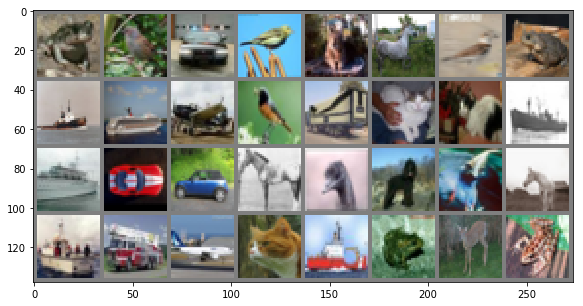

GT:  frog plane plane horse deer dog frog cat car car cat frog ship horse deer plane frog bird car cat plane deer bird horse ship cat car bird ship plane ship cat
Predicted:    frog bird horse truck deer horse frog cat car ship ship frog ship dog deer plane frog bird truck cat plane horse cat dog ship dog car bird ship car plane cat


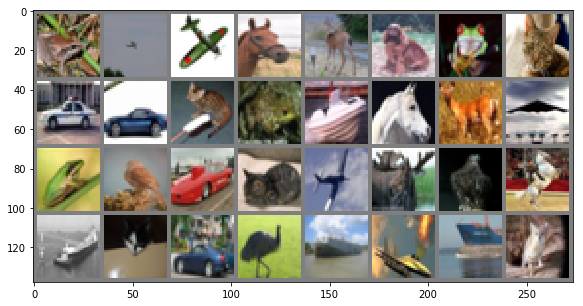

In [48]:
# Let's see what the network learned on some example images
for _ in range(2):
    images, labels = testdataiter.next()
    images, labels = images.to(device), labels.to(device)

    # Show the input images
    plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(torchvision.utils.make_grid(images).cpu().numpy() / 2 + 0.5, (1, 2, 0)))
    print('GT: ', ' '.join(classes[labels[j]] for j in range(iterBatchSize)))

    # Output predicted by our net
    outputs = net(images)
    # Predicted class = index of max probability (treating output as probability)
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted:   ', ' '.join(classes[predicted[j]] for j in range(iterBatchSize)))
    plt.show()

In [49]:
# Overall accuracy on the test set
correct, total = 0, 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    predicted = torch.argmax(outputs, dim=1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 57 %


In [50]:
# What are the accuracies per class?
nClasses = 10
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    predicted = torch.argmax(outputs, dim=1)
    c = (predicted == labels).squeeze()

    for i in range(labels.size(0)):
        label = labels[i]
        class_correct[label] += c[i].float()
        class_total[label] += 1

for i in range(nClasses):
    print('Accuracy of {} : {:6.2f}'.format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  56.80
Accuracy of car :  67.00
Accuracy of bird :  38.30
Accuracy of cat :  47.10
Accuracy of deer :  37.80
Accuracy of dog :  44.30
Accuracy of frog :  72.80
Accuracy of horse :  68.40
Accuracy of ship :  75.70
Accuracy of truck :  67.60


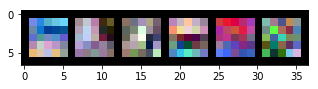

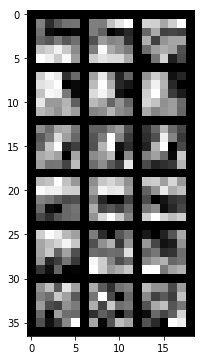

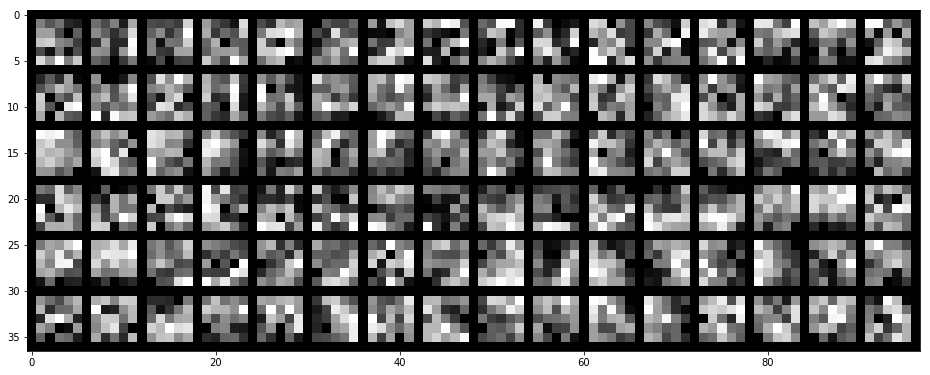

In [52]:
# Recall the kernels were gaussian random noise at the start
vistensor(net.conv1.weight.data)
vistensor(net.conv1.weight.data, allkernels=True, ncol=3)
vistensor(net.conv2.weight.data, allkernels=True,ncol=16)

## Visualizing Conv Nets

Now, we will investigate a popular technique for inspecting how CNNs make classification decisions. We look at Guided Grad CAM. We will also see such a method might allow us to spot adversarial examples.

### Utilities for Visualization

This code is taken from the following cool repo https://github.com/utkuozbulak/pytorch-cnn-visualizations
Go through it on your own time to understand what is going on, but for now we will just use it to see what we can do with it.

In [75]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map

import torch
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('results'):
        os.makedirs('results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def save_image(im, path):
    """
        Saves a numpy matrix of shape D(1 or 3) x W x H as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, np.ndarray):
        if len(im.shape) == 2:
            im = np.expand_dims(im, axis=0)
        if im.shape[0] == 1:
            # Converting an image with depth = 1 to depth = 3, repeating the same values
            # For some reason PIL complains when I want to save channel image as jpg without
            # additional format in the .save()
            im = np.repeat(im, 3, axis=0)
            # Convert to values to range 1-255 and W,H, D
        if im.shape[0] == 3:
            im = im.transpose(1, 2, 0) * 255
        im = Image.fromarray(im.astype(np.uint8))
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((512, 512))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_ten.requires_grad = True
    im_as_var = im_as_ten
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('input_images/snake.jpg', 56),
                    ('input_images/cat_dog.png', 243),
                    ('input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)


def normalize_gradient_image(gradient):
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    
    return gradient

In [54]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))
        # ^ I am extremely unhappy with this line. Originally resizing was done in cv2 which
        # supports resizing numpy matrices, however, when I moved the repository to PIL, this
        # option is out of the window. So, in order to use resizing with ANTIALIAS feature of PIL,
        # I briefly convert matrix to PIL image and then back.
        # If there is a more beautiful way, send a PR.
        return cam

In [55]:
from torch.nn import ReLU

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [56]:
def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask
    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

In [57]:
!mkdir input_images
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/spider.png?raw=true -O input_images/spider.png
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/dd_tree.jpg?raw=true -O input_images/dd_tree.jpg
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/snake.jpg?raw=true -O input_images/snake.jpg
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/cat_dog.png?raw=true -O input_images/cat_dot.png

mkdir: cannot create directory ‘input_images’: File exists
--2019-10-16 10:28:24--  https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/spider.png?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/utkuozbulak/pytorch-cnn-visualizations/raw/master/input_images/spider.png [following]
--2019-10-16 10:28:24--  https://github.com/utkuozbulak/pytorch-cnn-visualizations/raw/master/input_images/spider.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png [following]
--2019-10-16 10:28:24--  https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png
Resolving raw.githubusercontent.com (raw.githubusercontent

### Run Guided Grad Cam Example

In [58]:
plt.rcParams["axes.grid"] = False

# Get params
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(target_example)

# Grad cam
gcv2 = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = gcv2.generate_cam(prep_img, target_class)
print('Grad cam completed')

# Guided backprop
GBP = GuidedBackprop(pretrained_model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
print('Guided backpropagation completed')

# Guided Grad cam
cam_gb = guided_grad_cam(cam, guided_grads)
cam_gb_norm_orig = normalize_gradient_image(cam_gb)
cam_gb_norm_orig *= 255
cam_gb_norm_orig = Image.fromarray(cam_gb_norm_orig.astype("uint8").transpose(1, 2, 0))

grayscale_cam_gb_orig = convert_to_grayscale(cam_gb)
grayscale_cam_gb_orig = np.repeat(grayscale_cam_gb_orig, 3, axis=0)
grayscale_cam_gb_orig *= 255
grayscale_cam_gb_orig = Image.fromarray(grayscale_cam_gb_orig.astype("uint8").transpose(1, 2, 0))

Grad cam completed
Guided backpropagation completed


Text(0.5,1,'Grayscale Grad Cam')

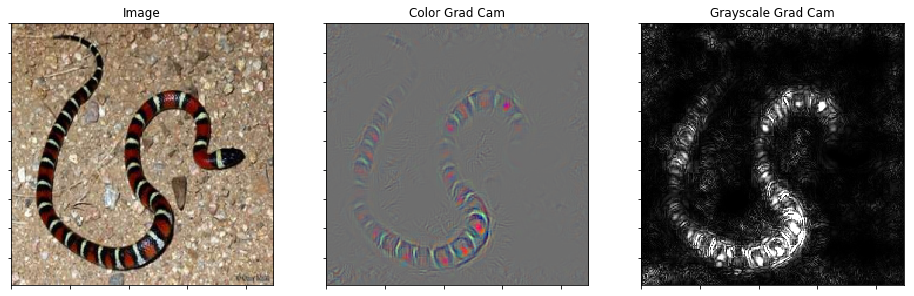

In [59]:
# Visualize the original image and the gradients
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 3, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(original_image)
ax.set_title("Image")

ax = fig.add_subplot(1, 3, 2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(cam_gb_norm_orig)
ax.set_title("Color Grad Cam")

ax = fig.add_subplot(1, 3, 3)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(grayscale_cam_gb_orig)
ax.set_title("Grayscale Grad Cam")

### Verifying Model Performance

Now let's see if our model predicts the correct class. Anything in the range of 52 to 68 is acceptable since these are all snake classes in ImageNet. If you'd like to see what a numeric class label means, look at: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [64]:
processed_image = preprocess_image(original_image)
original_output = pretrained_model(processed_image)
_, orig_pred = torch.max(original_output.data, 1)
print("Original Class Prediction: {}".format(orig_pred.item()))

Original Class Prediction: 60


### Creating Adversarial Examples

Note that we are using the simplest attack for this section, namely Fast Gradient Sign Method (FGSM). We are also making a very large perturbation so that we can fool the model for sure (epsilon of 0.3 is the largest you'll typically see in the literature). More clever attacks can fool the model by making smaller perturbations.

In [65]:
class AttackFGSM:
    def __init__(self, targeted=True, max_epsilon=0.21, min_epsilon=1e-10, norm=2,  # also supports 'inf'
                 optimize_epsilon=True, num_iter=None, cuda=True, debug=False):
        self.targeted = targeted
        self.eps = max_epsilon
        self.norm = float(norm)
        self.optimize_epsilon = optimize_epsilon
        if self.optimize_epsilon:
            self.num_iter = num_iter or 10

        self.loss_fn = torch.nn.CrossEntropyLoss()
        if cuda:
            self.loss_fn = self.loss_fn.cuda()
        self.debug = debug

    def generate_ad_ex(self, model, inputs, labels, targets=None, batch_num=0):  # Targets are not one hot encoded
        outputs = model(inputs)

        if outputs.is_cuda:
            idxout = torch.LongTensor(range(outputs.size()[0])).cuda()
            xones = torch.ones(outputs.size()[0]).cuda()
        else:
            idxout = torch.LongTensor(range(outputs.size()[0]))
            xones = torch.ones(outputs.size()[0])

        if self.targeted:
            attack_loss = outputs[idxout, targets]
        else:
            # negative sign below gives us correct direction for attack
            attack_loss = -1*outputs[idxout, labels]

        attack_loss.backward(xones)
        grad_sign = torch.sign(inputs.grad)
        delta = self.eps * grad_sign
        ad_inputs = inputs + delta

        return ad_inputs

In [66]:
fgs = AttackFGSM(targeted=False, optimize_epsilon=False, max_epsilon=0.6)
perturbed_image = fgs.generate_ad_ex(pretrained_model, processed_image, orig_pred)

We can see that now our model will predict the wrong label. In this case, it thinks the image is of a bib!

In [67]:
perturbed_output = pretrained_model(perturbed_image)
_, adv_pred = torch.max(perturbed_output.data, 1)
print("Perturbed class prediction: {}".format(adv_pred.item()))

Perturbed class prediction: 443


In [68]:
# Just converting from pytorch tensors to PIL image formatting, undoing the normalization as well
recreated_perturbed = recreate_image(perturbed_image)
print(recreated_perturbed.shape)
type(recreated_perturbed)
recreated_perturbed = Image.fromarray(recreated_perturbed.astype("uint8"))

(224, 224, 3)


Text(0.5,1,'Adversarial')

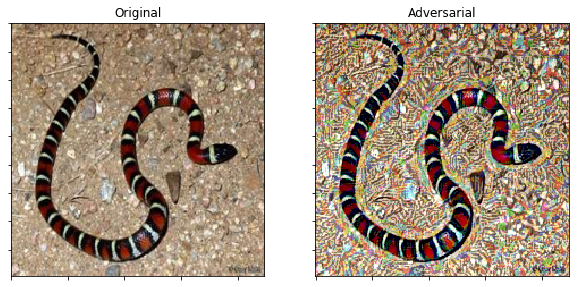

In [69]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(original_image)
ax.set_title("Original")

ax = fig.add_subplot(1, 2, 2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(recreated_perturbed)
ax.set_title("Adversarial")

### Grad Cam on Adversarial Example

Now let's see what our model is paying attention to when making this incorrect classification.

In [70]:
# Guided backprop
GBP = GuidedBackprop(pretrained_model)
# Get gradients
prep_img = preprocess_image(recreated_perturbed)
guided_grads = GBP.generate_gradients(prep_img, adv_pred.item())
print('Guided backpropagation completed')

# Guided Grad cam
cam_gb = guided_grad_cam(cam, guided_grads)
cam_gb_norm_adv = normalize_gradient_image(cam_gb)
cam_gb_norm_adv *= 255
cam_gb_norm_adv = Image.fromarray(cam_gb_norm_adv.astype("uint8").transpose(1, 2, 0))

grayscale_cam_gb_adv = convert_to_grayscale(cam_gb)
grayscale_cam_gb_adv = np.repeat(grayscale_cam_gb_adv, 3, axis=0)
grayscale_cam_gb_adv *= 255
grayscale_cam_gb_adv = Image.fromarray(grayscale_cam_gb_adv.astype("uint8").transpose(1, 2, 0))

Guided backpropagation completed


Text(0.5,1,'Grayscale Grad Cam')

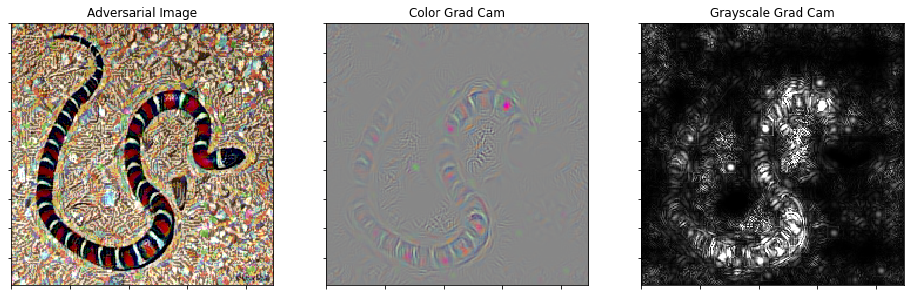

In [71]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 3, 1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(recreated_perturbed)
ax.set_title("Adversarial Image")

ax = fig.add_subplot(1, 3, 2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(cam_gb_norm_adv)
ax.set_title("Color Grad Cam")

ax = fig.add_subplot(1, 3, 3)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.imshow(grayscale_cam_gb_adv)
ax.set_title("Grayscale Grad Cam")

Notice how if you compare these grad cam visualizations to the ones on the original image, these ones have more noise in them and appear more diffuse, i.e. they are less focused on the snake.